# Chapter 4: Building Causal Diagrams From Scratch

## Business problem and data setup

### Data and libraries

In [23]:
#Standard libraries
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

#Chapter specific libraries
from math import sqrt
from scipy.stats import chi2_contingency 

In [2]:
#Loading the data
dat_df = pd.read_csv("chap4-hotel_booking_case_study.csv")

In [3]:
#Reducing the number of values for Country of origin by keeping most frequent countries only
#and aggregating the remaining ones under "Other"
countries_df = dat_df.groupby('Country').agg(pct = ('NRDeposit', lambda x: len(x)/len(dat_df))).\
sort_values(by=['pct'], ascending = False)
top_countries_df = countries_df.loc[countries_df.pct >= 0.01].reset_index()
top_countries_lst = top_countries_df['Country'].tolist()
print(top_countries_lst)
dat_df['Country'] = np.where(dat_df['Country'].isin(top_countries_lst), dat_df['Country'], 'Other')

['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE', 'CN', 'AUT']


### Understanding the relationship of interest

In [4]:
#Cancellation rate by deposit types
table_cnt = dat_df.groupby(['NRDeposit', 'IsCanceled']).\
agg(cnt = ('Country', lambda x: len(x)))
print(table_cnt)

                        cnt
NRDeposit IsCanceled       
0         0           63316
          1           23042
1         0              55
          1             982


In [6]:
table_pct = table_cnt.groupby(level=0).apply(lambda x: x/float(x.sum()))
print(table_pct)

                           cnt
NRDeposit IsCanceled          
0         0           0.733180
          1           0.266820
1         0           0.053038
          1           0.946962


## Validate observable variables to include based on data

In [7]:
### Applying Cramer's V
#Formula from https://en.wikipedia.org/wiki/Cram%C3%A9r's_V

def  CramerV(var1, var2):
    pivot_tb = pd.crosstab(var1, var2, margins=False)
    chi_sq, _, _, _ = chi2_contingency(pivot_tb) 
    n = len(var1)
    k = len(var1.unique())
    r = len(var2.unique())
    V = sqrt((chi_sq/n)/(min(k-1, r-1)))
    return V

V= CramerV(dat_df['NRDeposit'], dat_df['IsCanceled'])   
print(V)

0.16483946381640308


### Relationships between numeric variables

In [8]:
#Shortening column names
dat_df.rename(columns=
              {"CustomerType": "CustTyp",
               "DistributionChannel": "DistCh",
               "IsRepeatedGuest": "RepGst",
               "MarketSegment": "MktSgmt",
               "IsCanceled": "IsCanc",
               "PreviousCancellations": "PrevCan",
               "NRDeposit": "NRDep"},
              inplace=True)
print(dat_df.columns)

Index(['NRDep', 'IsCanc', 'DistCh', 'MktSgmt', 'CustTyp', 'Children', 'ADR',
       'PrevCan', 'RepGst', 'Country', 'Quarter', 'Year'],
      dtype='object')


In [9]:
#Creating a dataframe with the numerical and binary variables only
num_dat_df = dat_df.copy().select_dtypes(include=['int64', 'float64'])
num_dat_df.columns

Index(['NRDep', 'IsCanc', 'Children', 'ADR', 'PrevCan', 'RepGst', 'Year'], dtype='object')

             NRDep    IsCanc  Children       ADR   PrevCan    RepGst      Year
NRDep     1.000000  0.164958 -0.032703 -0.040040  0.149858 -0.016099 -0.019110
IsCanc    0.164958  1.000000  0.060165  0.133467  0.126891 -0.089640  0.088037
Children -0.032703  0.060165  1.000000  0.339825 -0.028195 -0.047242  0.034155
ADR      -0.040040  0.133467  0.339825  1.000000 -0.073385 -0.161620  0.186587
PrevCan   0.149858  0.126891 -0.028195 -0.073385  1.000000  0.246987 -0.119020
RepGst   -0.016099 -0.089640 -0.047242 -0.161620  0.246987  1.000000  0.024342
Year     -0.019110  0.088037  0.034155  0.186587 -0.119020  0.024342  1.000000


C:\Users\Florent\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:>

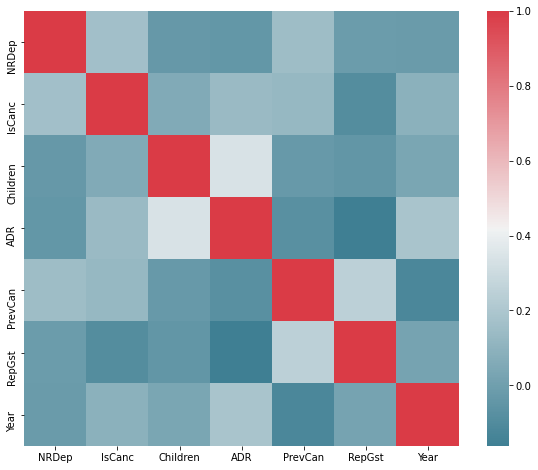

In [10]:
#Creating the correlation matrix for numerical and binary variables only
num_corr = num_dat_df.corr()
print(num_corr)

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(num_corr, mask=np.zeros_like(num_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Relationships between categorical variables

In [11]:
#Convert variables to categorical 
dat_df['NRDep'] = pd.Categorical(dat_df.NRDep)
dat_df['IsCanc'] = pd.Categorical(dat_df.IsCanc)
dat_df['DistCh'] = pd.Categorical(dat_df.DistCh)
dat_df['MktSgmt'] = pd.Categorical(dat_df.MktSgmt)
dat_df['CustTyp'] = pd.Categorical(dat_df.CustTyp)
dat_df['PrevCan'] = pd.Categorical(dat_df.PrevCan)
dat_df['RepGst'] = pd.Categorical(dat_df.RepGst)
dat_df['Country'] = pd.Categorical(dat_df.Country)
dat_df['Quarter'] = pd.Categorical(dat_df.Quarter)
dat_df.dtypes

NRDep       category
IsCanc      category
DistCh      category
MktSgmt     category
CustTyp     category
Children       int64
ADR          float64
PrevCan     category
RepGst      category
Country     category
Quarter     category
Year           int64
dtype: object

varJ      Country   CustTyp    DistCh    IsCanc   MktSgmt     NRDep   PrevCan  \
varI                                                                            
Country  1.000000  0.111580  0.160096  0.159473  0.168515  0.149508  0.188658   
CustTyp  0.111580  1.000000  0.088851  0.127065  0.326992  0.010640  0.066364   
DistCh   0.160096  0.088851  1.000000  0.152114  0.734199  0.032245  0.143917   
IsCanc   0.159473  0.127065  0.152114  0.999971  0.220722  0.164839  0.126797   
MktSgmt  0.168515  0.326992  0.734199  0.220722  1.000000  0.283656  0.168677   
NRDep    0.149508  0.010640  0.032245  0.164839  0.283656  0.999512  0.149473   
PrevCan  0.188658  0.066364  0.143917  0.126797  0.168677  0.149473  0.999697   
Quarter  0.082805  0.061455  0.069202  0.071384  0.072494  0.031931  0.060018   
RepGst   0.229291  0.108399  0.353780  0.089574  0.395924  0.015826  0.246773   

varJ      Quarter    RepGst  
varI                         
Country  0.082805  0.229291  
CustTyp  0.061455 

C:\Users\Florent\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<AxesSubplot:xlabel='varJ', ylabel='varI'>

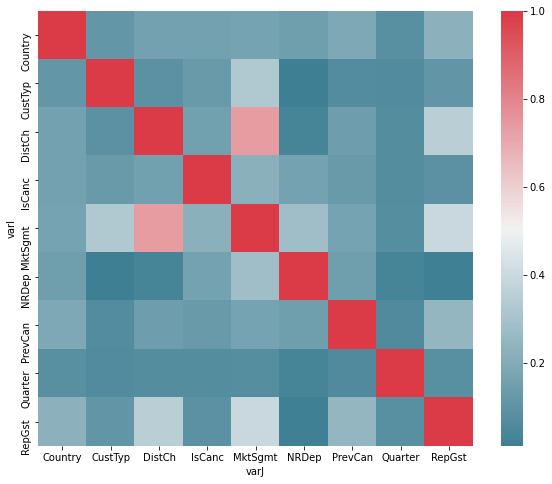

In [12]:
# Calculating correlation matrix for the categorical and binary variables only
def cat_corr_fun(dat_df):
    
    #Initialize output dataframe
    cat_corr_df = pd.DataFrame(columns=['varI', 'varJ', 'corr'])
    
    #Subset to categorical variables only
    cat_dat_df = dat_df.select_dtypes(exclude=['int64', 'float64'])
    
    
    for varI in cat_dat_df.columns:
        for varJ in cat_dat_df.columns:
                corr = CramerV(cat_dat_df[varI], cat_dat_df[varJ])
                row = pd.Series(data={'varI':varI, 'varJ':varJ, 'corr':corr})
                cat_corr_df = cat_corr_df.append(row, ignore_index=True)
    return(cat_corr_df)
cat_corr_df = cat_corr_fun(dat_df)
cat_corr = pd.pivot_table(cat_corr_df, index=['varI'], columns=['varJ'], values=['corr'], fill_value=1)
cat_corr.columns = cat_corr.columns.droplevel(0)
print(cat_corr)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cat_corr, mask=np.zeros_like(cat_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Correlations between numeric and categorical variables

In [16]:
dat_df.groupby('CustTyp').agg(mean_ADR = ('ADR', np.mean))

,mean_ADR
CustTyp,
Contract,92.753036
Group,84.361949
Transient,110.062373
Transient-Party,87.675056


In [17]:
dat_df.groupby('Country').agg(mean_year = ('Year', np.mean))

,mean_year
Country,
AUT,2016.327350
BEL,2016.350793
BRA,2016.390476
CHE,2016.340127
CN,2016.426349
DEU,2016.346389
ESP,2016.133205
FRA,2016.275546
GBR,2016.319371


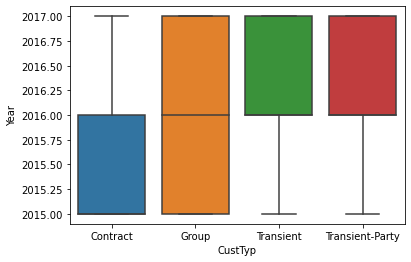

In [18]:
sns.boxplot(y=dat_df['Year'], x=dat_df['CustTyp'])
plt.show()

In [21]:
lin_mod = ols("Year~CustTyp", data=dat_df).fit()
print(lin_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   Year   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1216.
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:14:12   Log-Likelihood:                -89296.
No. Observations:               87395   AIC:                         1.786e+05
Df Residuals:                   87391   BIC:                         1.786e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [27]:
### Regression analysis

#Single explanatory variable
dat_df['IsCanc'] = dat_df.IsCanc.astype('int') #Converting back to binary for regression
smf.logit('IsCanc ~ NRDep', data = dat_df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.575647
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 IsCanc   No. Observations:                87395
Model:                          Logit   Df Residuals:                    87393
Method:                           MLE   Df Model:                            1
Date:                Thu, 24 Jun 2021   Pseudo R-squ.:                 0.02111
Time:                        11:22:57   Log-Likelihood:                -50309.
converged:                       True   LL-Null:                       -51394.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0108      0.008   -131.383      0.000      -1.026      -0.996
NRDep[T.1]     3.8931      0.139     28.053      0.000       3.621       4.165
==============================================================================
"""

In [30]:
# Complete model 
formula = """IsCanc ~ NRDep + DistCh + MktSgmt + CustTyp + Children + ADR + PrevCan +
RepGst + Country + Quarter + Year"""

smf.logit(formula, data = dat_df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.498922
         Iterations 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 IsCanc   No. Observations:                87395
Model:                          Logit   Df Residuals:                    87360
Method:                           MLE   Df Model:                           34
Date:                Thu, 24 Jun 2021   Pseudo R-squ.:                  0.1516
Time:                        11:27:08   Log-Likelihood:                -43603.
converged:                       True   LL-Null:                       -51394.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -947.7606     31.227    -30.351      0.000   -1008.964    -886.557
NRDep[T.1]                     3.6616      0.149     24.582      0.000       3.370       3.954
DistCh[T.Direct]              -0.0892      0.109     -0.821      0.411      -0.302       0.124
DistCh[T.Other]               -0.0124      0.210     -0.059      0.953      -0.425       0.400
DistCh[T.TA/TO]                0.4481      0.100      4.500      0.000       0.253       0.643
MktSgmt[T.Direct]              0.3708      0.120      3.095      0.002       0.136       0.606
MktSgmt[T.Groups]              0.8627      0.108      7.967      0.000       0.650       1.075
MktSgmt[T.Offline TA/TO]       0.1630      0.112      1.449      0.147      -0.057       0.383
MktSgmt[T.Online TA]           1.2799      0.111     11.539      0.000       1.063       1.497
MktSgmt[T.Other]               0.3604      0.130      2.765      0.006       0.105       0.616
CustTyp[T.Group]              -0.0480      0.169     -0.285      0.776      -0.378       0.282
CustTyp[T.Transient]           0.6930      0.061     11.316      0.000       0.573       0.813
CustTyp[T.Transient-Party]    -0.0280      0.069     -0.407      0.684      -0.162       0.107
PrevCan[T.1]                   3.3362      0.092     36.161      0.000       3.155       3.517
RepGst[T.1]                   -2.7172      0.099    -27.353      0.000      -2.912      -2.523
Country[T.BEL]                 0.0703      0.105      0.672      0.502      -0.135       0.275
Country[T.BRA]                 0.8687      0.100      8.656      0.000       0.672       1.065
Country[T.CHE]                 0.2741      0.107      2.568      0.010       0.065       0.483
Country[T.CN]                  0.1469      0.117      1.252      0.210      -0.083       0.377
Country[T.DEU]                 0.1101      0.095      1.163      0.245      -0.076       0.296
Country[T.ESP]                 0.5236      0.092      5.672      0.000       0.343       0.704
Country[T.FRA]                 0.1341      0.092      1.457      0.145      -0.046       0.314
Country[T.GBR]                 0.2387      0.092      2.605      0.009       0.059       0.418
Country[T.IRL]                 0.3420      0.099      3.454      0.001       0.148       0.536
Country[T.ITA]                 0.9292      0.096      9.633      0.000       0.740       1.118
Country[T.NLD]                -0.0112      0.107     -0.105      0.917      -0.220       0.198
Country[T.Other]               0.6729      0.091      7.429      0.000       0.495       0.850
Country[T.PRT]                 1.4841      0.089     16.595      0.000       1.309       1.659
Country[T.USA]                 0.3163      0.104      3.039      0.002       0.112       0.520
Quarter[T.Q2]                  0.3183      0.026     12.370      0.000       0.268       0.369
Quarter[T.Q3]                  0.3530      0.028     12.472      0.000       0.298       0.409
Quarter[T.Q